<a href="https://colab.research.google.com/github/pedro-de-bastos/CS166-Modeling-Simulation-and-Decision-Making/blob/main/CS166_Final_Cellular_Automata_for_Cane_Toads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS166 Final: Modelling Ecological Systems

By Pedro M. de Bastos

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker
import scipy.special as sps
import scipy.stats as sts

# The Lotka-Volterra Model


In [2]:
#The following function implements the change in population based on the Lokta-Volterra difference equations
def update_pop(init, A, r):#Init is the initial populations for the different species
    return(init+(np.matmul(A, init)+init*r))

In [3]:
x = 4 #x is the multiplication factor for the toad population, see the line below
init = np.array([100, 100*x, 100, 100]).reshape(-1, 1) #this has to be a column vector for multiplication with the function I defined above
track = np.zeros((10000, 4)) #I will keep the values for the popluations in this NP array as I update them
track[0, :] = init.flatten() #the first row is the initial population values

#This community matrix, together with the r matrix below, leads to a difference of population of zero for each species, so long as the populations become equal (which they eventually tend to do)
#Note how the rows of A encode what happens to each species based on the other species.
#for example, the first row encodes what happens to the population of crocs. For the population of crocs,
#We multiply the population of toads by 0.1 and add that number to the population of crocs.
A = np.array([[0, 0.1, 0, 0], [-0.1, 0, 0.2, 0], [0, -0.1, 0, 0.2], [0, 0, -0.1, 0]])
r = np.array([-0.1,-0.1,-0.1,0.1]).reshape(-1, 1)


#Running the Lotka-Volterra update equation for 10000 updates and storing the results:
for i in range(1, 10000):
  init = update_pop(init, A, r)
  track[i,:] = init.flatten() 

In [4]:
A = np.array([[0, 0.1, 0, 0], [-0.1, 0, 0.2, 0], [0, -0.1, 0, 0.2], [0, 0, -0.1, 0]]) #This community matrix, together with the r matrix below, leads to a difference of population of zero for each species, so long as the populations become equal (which they eventually tend to do)
r = np.array([-0.1,-0.1,-0.1,0.1]).reshape(-1, 1)
#It is a property of the lotka volterra equations that x = -A**(-1)*r, where x is the proportions of the populaiton at equilibrium. In this case, at equilibrium all populations are the same, by design.
np.matmul(-np.linalg.inv(A), r)

array([[1.],
       [1.],
       [1.],
       [1.]])

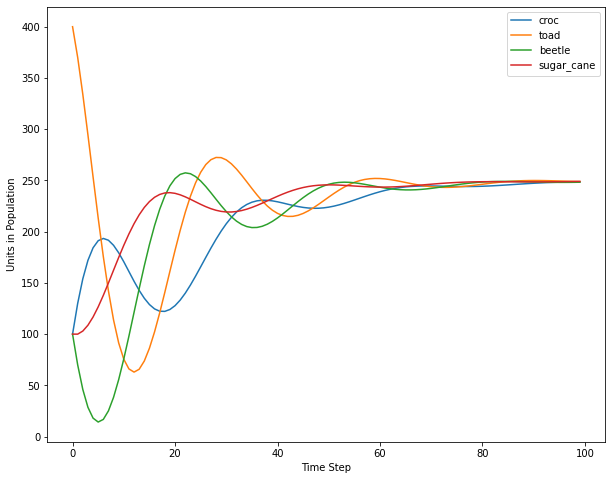

In [5]:
#Plotting the outcomes:
import matplotlib.pyplot as plt

species = ['croc', 'toad', 'beetle', 'sugar_cane']

plt.figure(figsize=(10, 8))

for i in [0, 1, 2, 3]:
  plt.plot(range(len(track[0:100,i])), track[0:100,i], label = species[i])

plt.xlabel("Time Step")
plt.ylabel("Units in Population")
plt.legend()

In [6]:
#I used the following loop to answer the question: how many more times larger does the toad population have to be such that the beetle population is dirven to 0?
#Takes around 30 seconds to run
x = 0 #This is the multiplication factor for the populaiton of toads. It begins at zero, and it is slowly driven up until the population of beetles goes below zero
extinction = False

while extinction == False: 
  x += 0.01 #we increase x slowly
  init = np.array([100, 100*x, 100, 100]).reshape(-1, 1) 
  track = np.zeros((10000, 4))
  for i in range(1, 10000):
    init = update_pop(init, A, r)
    track[i,:] = init.flatten()
  if sum(track[:, 2] < 0)>0: #We track whether the column with the populations of beetles has any values smaller or equal to zero
    extinction = True

print(x)

4.4999999999999485


# Cellular Automata

I implemented my CA using a class. This allows me to store important data easily, change variable values dynamically, and importantly, have an easy way to run the CA several times (much less messy than global variables).

In [7]:
class lotka_ca:
  def __init__(self, gridsize=100, reproduction_rate = {'croc':0, 'toad':0, 'beetle':0, 'cane':0.2}, densities = {'croc':0.1, 'toad':0.1, 'beetle':0.1, 'cane':0.1}, success_rate = {'croc':0.05, 'toad':0.2, 'beetle':0.4, 'cane':0}, death_rate = {'croc':0.02, 'toad':0.05, 'beetle':0.05, 'cane':0}, hunt_birth_rate = {'croc':1, 'toad':1, 'beetle':1, 'cane':0}):
    
    
    self.gridsize = gridsize #How big do we want the grid to be?
    self.steps = 0 #No idea why I have this here but I'm not removing it in case it breaks something
    self.grid = np.zeros(gridsize**2) #Creating the grid

    self.species_code = {} #This is a dictionary that has as keys numbers that will represent the different species on the CA grid, and as values the name of the species
    self.species_number = {} #This is the opposite dictionary to the one above (keys are species names, values are the number values for those species on the CA grid)
    self.densities = {} #The initial densities for each population
    self.densities_history = {} #The history of densities will be recorded here
    self.success_rate = {} #The hunt success rate, for each species
    self.death_rate = {} #The death rate for each species
    self.hunt_birth_rate = {} #How frequently does each species produce offspring with every successful hunt
    self.reproduction_rate = {}

    
    code = 1 #The code starts at 1 for crocodiles, 0 is empty spaces on the CA grid
    for i in densities.keys(): #In this loop I get the values from the __init__ call and store them as attributes of the class
      self.species_code[code] = i
      self.species_number[i] = code
      code += 1
      self.densities[i] = densities[i]
      self.densities_history[i] = [densities[i]]
      self.success_rate[i] = success_rate[i]
      self.reproduction_rate[i] = reproduction_rate[i]
      self.hunt_birth_rate[i] = hunt_birth_rate[i]
      self.death_rate[i] = death_rate[i]

    for i in self.densities.keys(): #based on the densities, this loop will populate the grid with randomly allocated organisms
      empty_spots = np.where(self.grid==0)[0]
      chosen_indices = np.random.choice(empty_spots, size = int(self.densities[i]*gridsize**2), replace=False)
      self.grid[chosen_indices] = self.species_number[i]

    self.grid = self.grid.reshape((gridsize, gridsize)) #Shaping the grid appropriately

  def hunt(self, x, y, predator, prey, new_grid):
    targets = []
    for dx in range(-2, 3):
      for dy in range(-2, 3):
        if self.grid[(x+dx)%self.gridsize, (y+dy)%self.gridsize] == prey: #if the neighbor is a toad:
          targets.append(((x+dx)%self.gridsize, (y+dy)%self.gridsize))
    if len(targets) != 0:
      target_choice = np.random.choice(range(len(targets)))
      target_choice = targets[target_choice]
      if np.random.random() < self.success_rate[self.species_code[self.grid[x, y]]]:
        new_grid[target_choice[0], target_choice[1]] = 0
        if np.random.random() < self.hunt_birth_rate[self.species_code[self.grid[x, y]]]:
          targets = [] #the cells that the offspring can occupy
          for dx in range(-2, 3):
            for dy in range(-2, 3):
              if self.grid[(x+dx)%self.gridsize, (y+dy)%self.gridsize] == 0: #if the cell is empty:
                targets.append(((x+dx)%self.gridsize, (y+dy)%self.gridsize))
          try: #Try because there may be no empty spaces
            choice = np.random.choice(range(len(targets)))
            choice = targets[choice]
            new_grid[choice[0], choice[1]] = self.grid[x, y] #the offspring is born, same species as the parent
          except:
            done = True
    #else: #I tried the simulation out with another assumption: no food means animal dies
      #new_grid[x, y] = 0

  def predation(self):
    new_grid = self.grid.copy()
    for x in range(self.gridsize):
      for y in range(self.gridsize):
        if self.grid[x, y] == 1: #if its a croc
          self.hunt(x, y, 1, 2, new_grid)
        elif self.grid[x, y] == 2: #if its a toad
          self.hunt(x, y, 2, 3, new_grid)
        elif self.grid[x, y] == 3: #if its a beetle
          self.hunt(x, y, 3, 4, new_grid)
    self.grid = new_grid

  def procreation(self): #The procreation step used to produce offspring for all species, now it only does that for sugar cane
    new_grid = self.grid.copy()
    for x in range(self.gridsize):
      for y in range(self.gridsize):
        for species in [4]:
          if self.grid[x, y] == species:
            if np.random.random()<self.reproduction_rate[self.species_code[self.grid[x, y]]]: #if parents mate successfully
              targets = [] #the cells that the offspring can occupy
              for dx in range(-2, 3):
                for dy in range(-2, 3):
                  if self.grid[(x+dx)%self.gridsize, (y+dy)%self.gridsize] == 0: #if the cell is empty:
                    targets.append(((x+dx)%self.gridsize, (y+dy)%self.gridsize))
              try: #Try because there may be no empty spaces
                choice = np.random.choice(range(len(targets)))
                choice = targets[choice]
                new_grid[choice[0], choice[1]] = self.grid[x, y] #the offspring is born, same species as the parent
              except:
                continue
      self.grid = new_grid


  def natural_deaths(self):
    new_grid = self.grid.copy()
    for x in range(self.gridsize):
      for y in range(self.gridsize):
        if self.grid[x, y] != 0:
          if np.random.random()<self.death_rate[self.species_code[self.grid[x, y]]]:
            new_grid[x, y] = 0
    self.grid = new_grid

  def movement(self):
    new_grid = self.grid.copy()
    for x in range(self.gridsize):
      for y in range(self.gridsize):
        if self.grid[x, y] not in [0, 4]: #empty cells and sugar cane cannot move
          targets = [] #the cells that the offspring can occupy
          for dx in range(-2, 3):
            for dy in range(-2, 3):
              if self.grid[(x+dx)%self.gridsize, (y+dy)%self.gridsize] == 0: #if the cell is empty:
                targets.append(((x+dx)%self.gridsize, (y+dy)%self.gridsize))
          try:
            choice = np.random.choice(range(len(targets)))
            choice = targets[choice]
            new_grid[choice[0], choice[1]] = self.grid[x, y]
            new_grid[x, y] = 0
          except:
            done = True

  def update(self):
    self.predation()
    self.procreation() #With the latest update, procreation of sugar cane only
    self.natural_deaths()
    self.movement()
    for i in self.densities.keys():
      self.densities_history[i].append(np.sum(self.grid==self.species_number[i])/self.gridsize**2)
  
  def observe(self):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    cmap = mpl.colors.ListedColormap(['darkblue', 'Red', 'lightgreen', 'yellow', 'darkgreen'])
    im = ax1.imshow(self.grid, cmap = cmap)#, vmin = 1, vmax = 4)
    cb = f.colorbar(im, ax=ax1)
    cb.set_ticks([0.4, 1.2, 2.0, 2.8, 3.6])
    cb.set_ticklabels(['Empty', 'Croc', "Toad", "Beetle", "Cane"])

    colors = ['Red', 'lightgreen', 'yellow', 'darkgreen']
    for i, j in enumerate(['croc', 'toad', 'beetle', 'cane']):
      ax2.plot(self.densities_history[j], label = str(j), color = colors[i])


    f.legend()
    f.show()

# Random Parameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


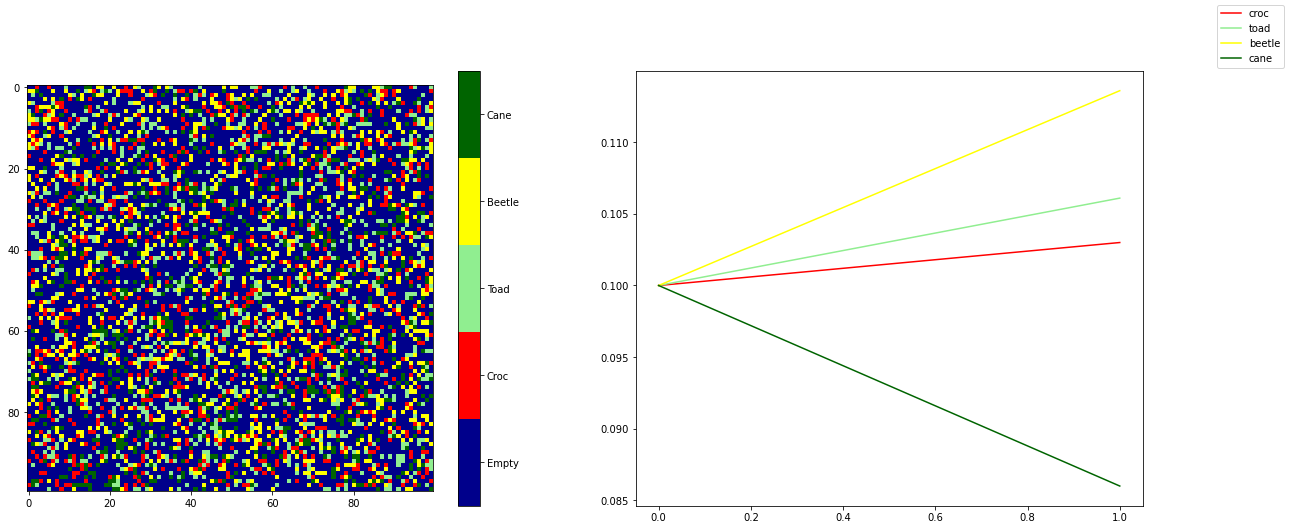

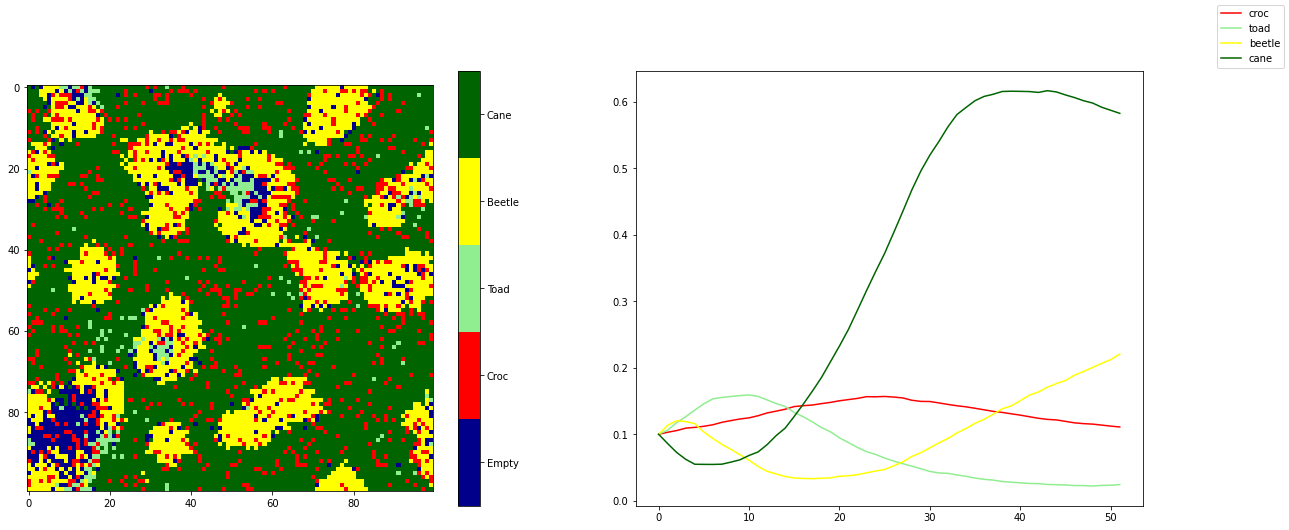

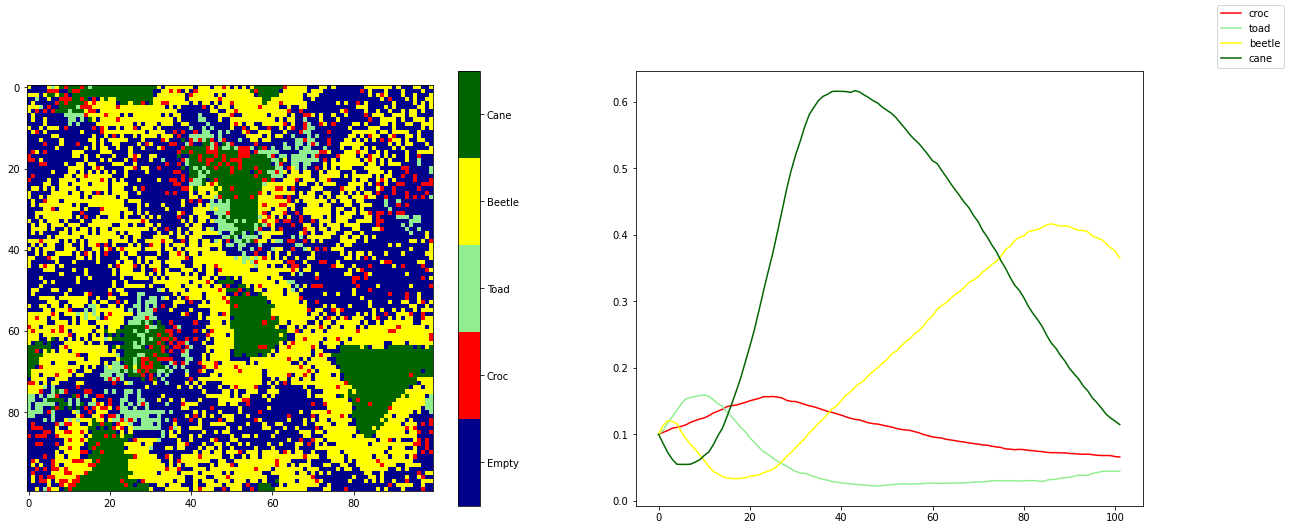

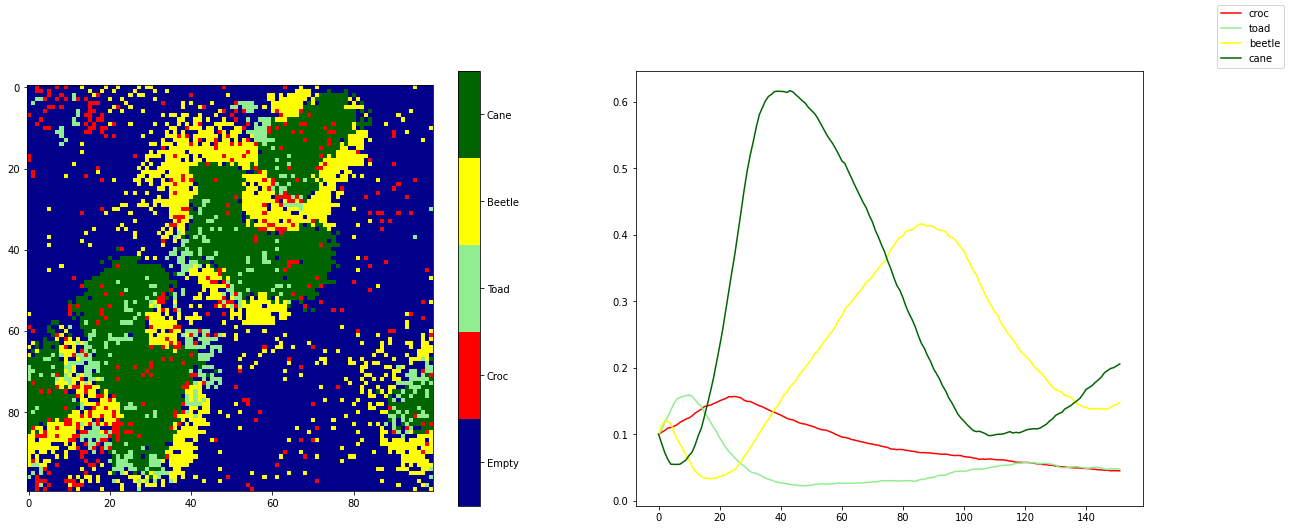

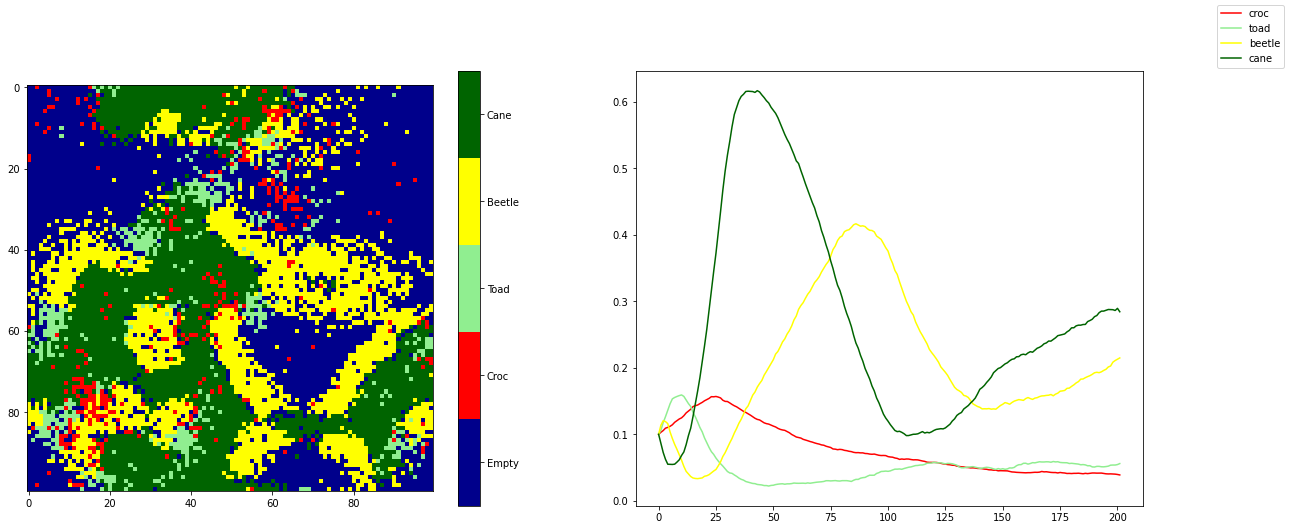

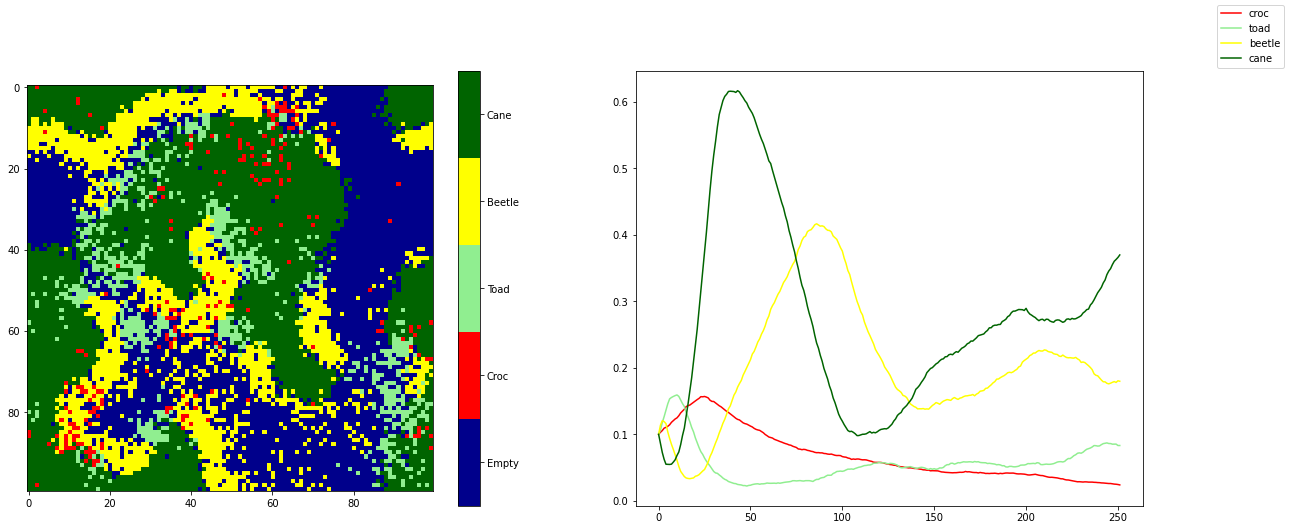

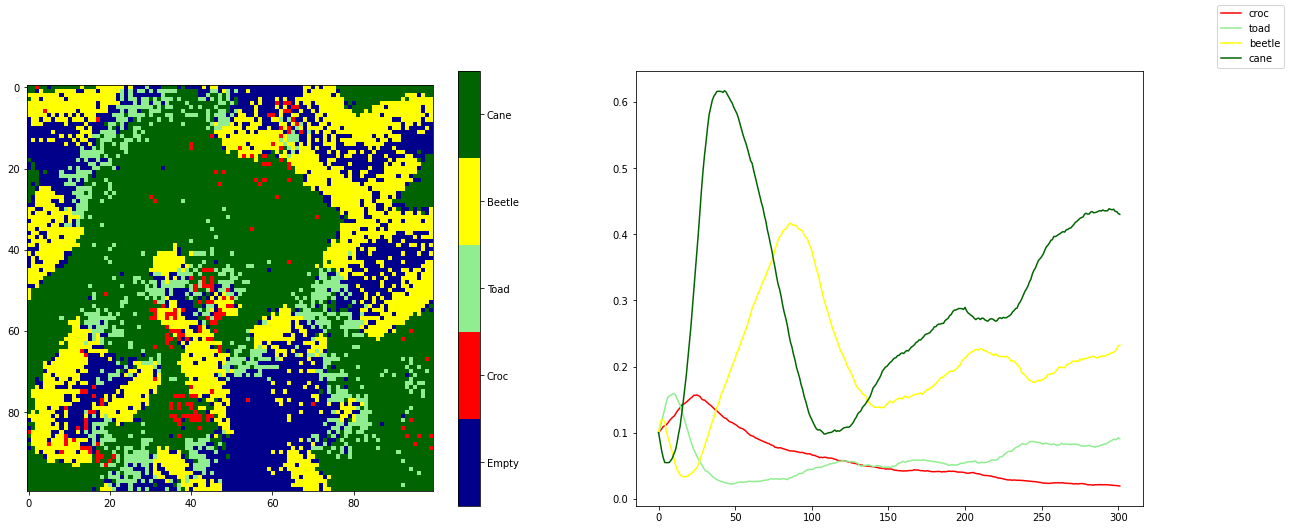

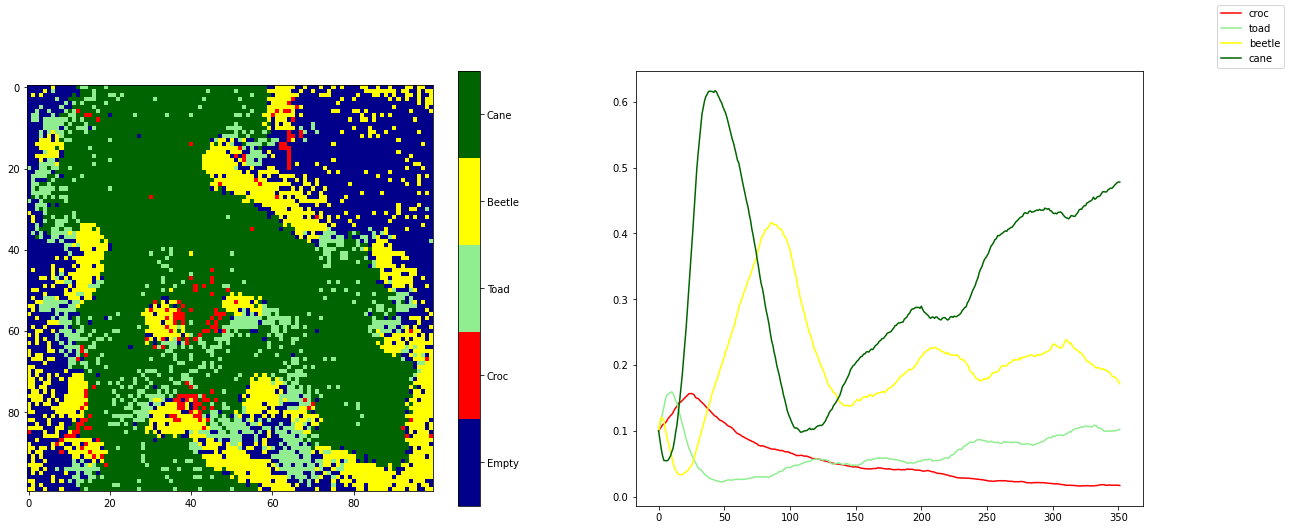

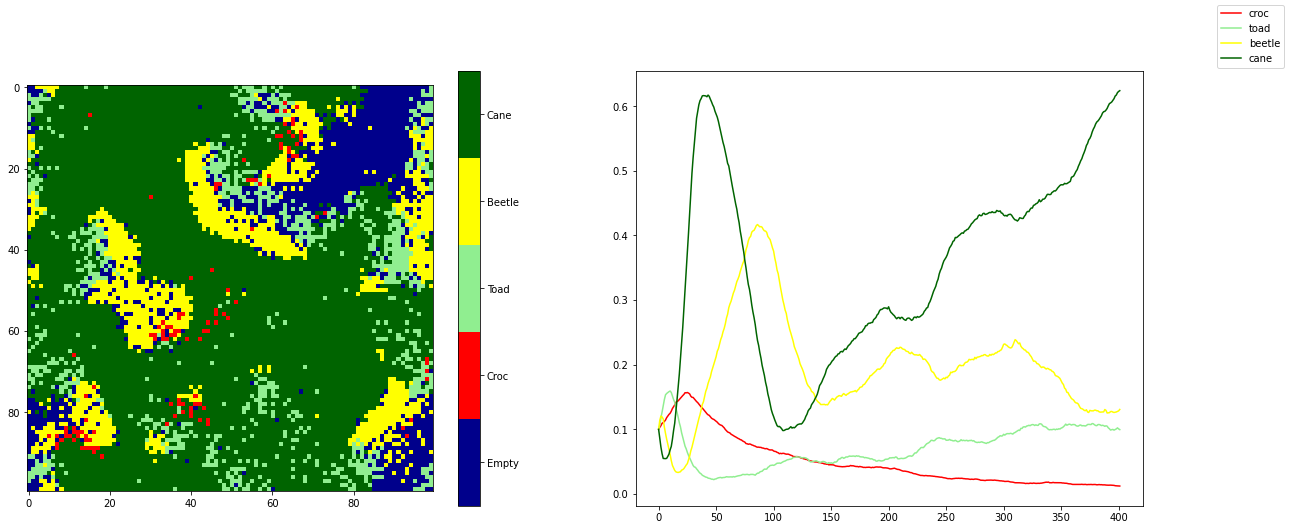

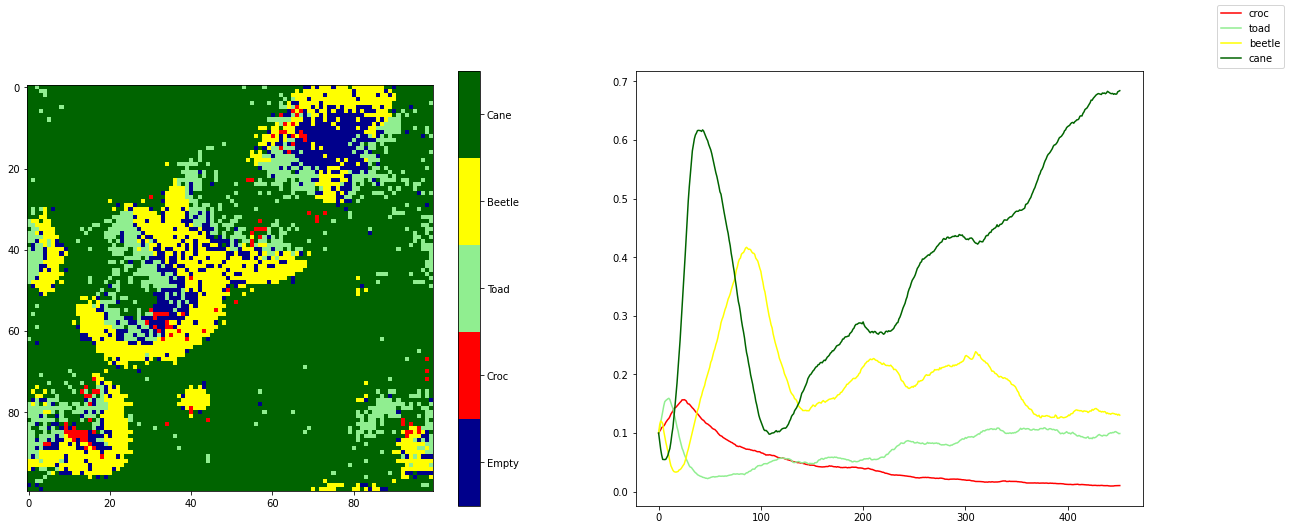

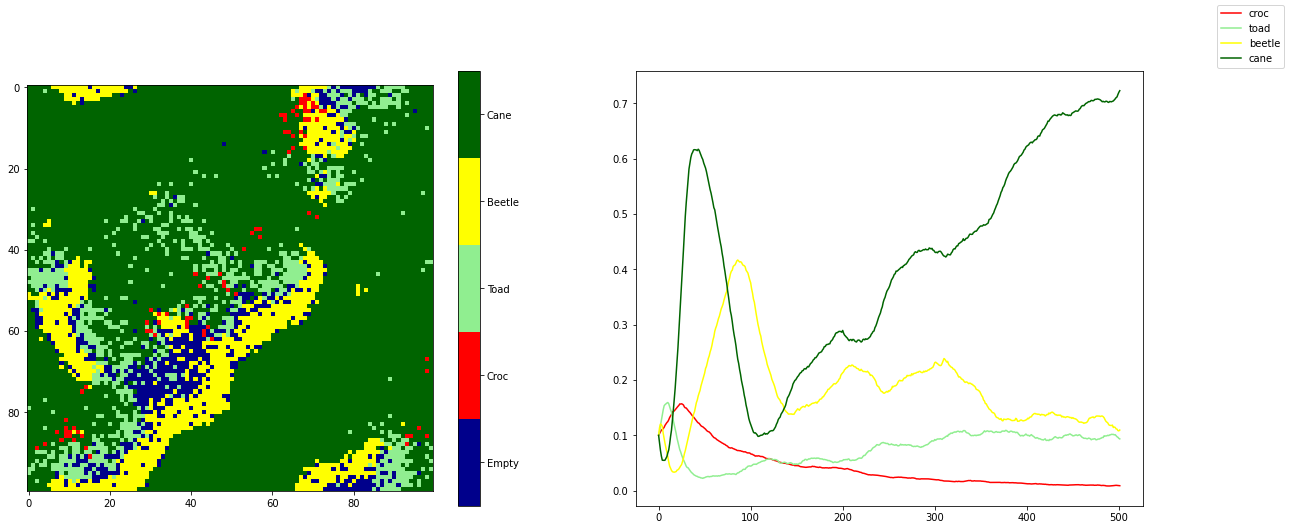

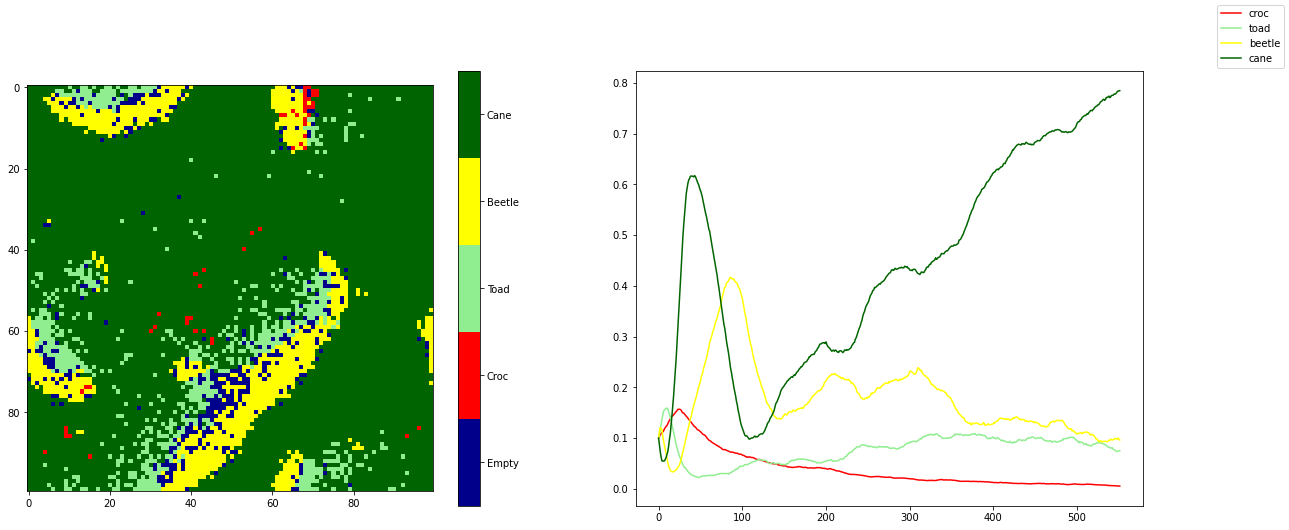

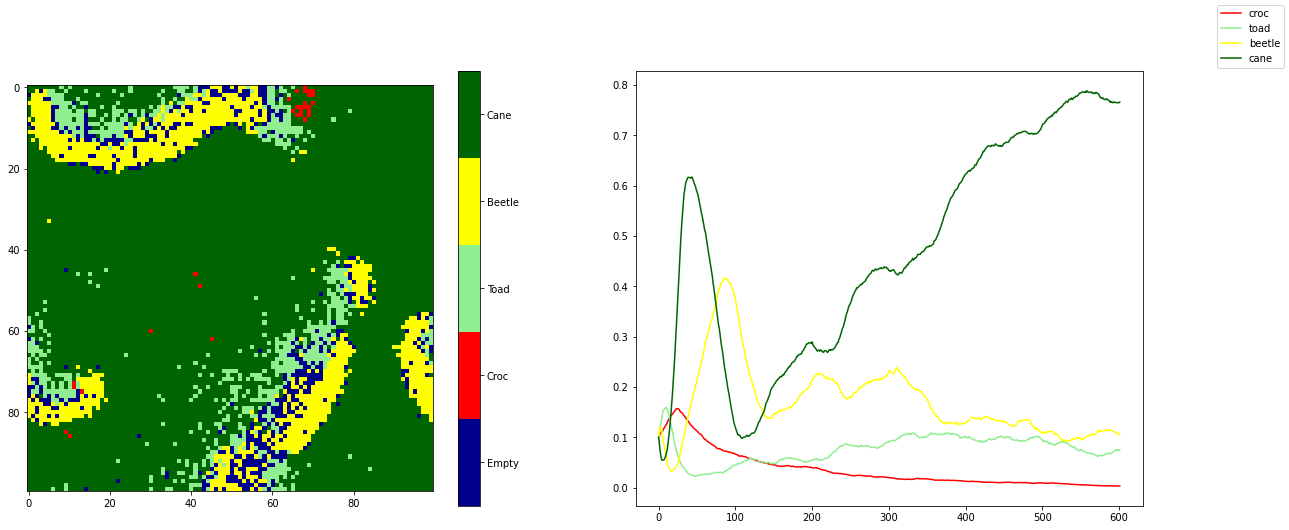

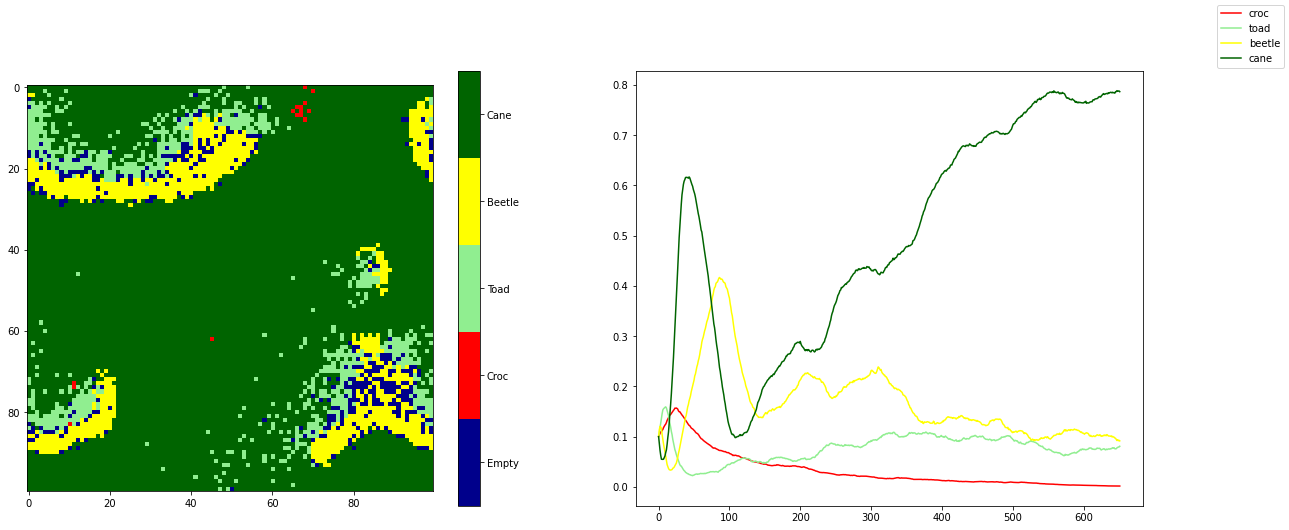

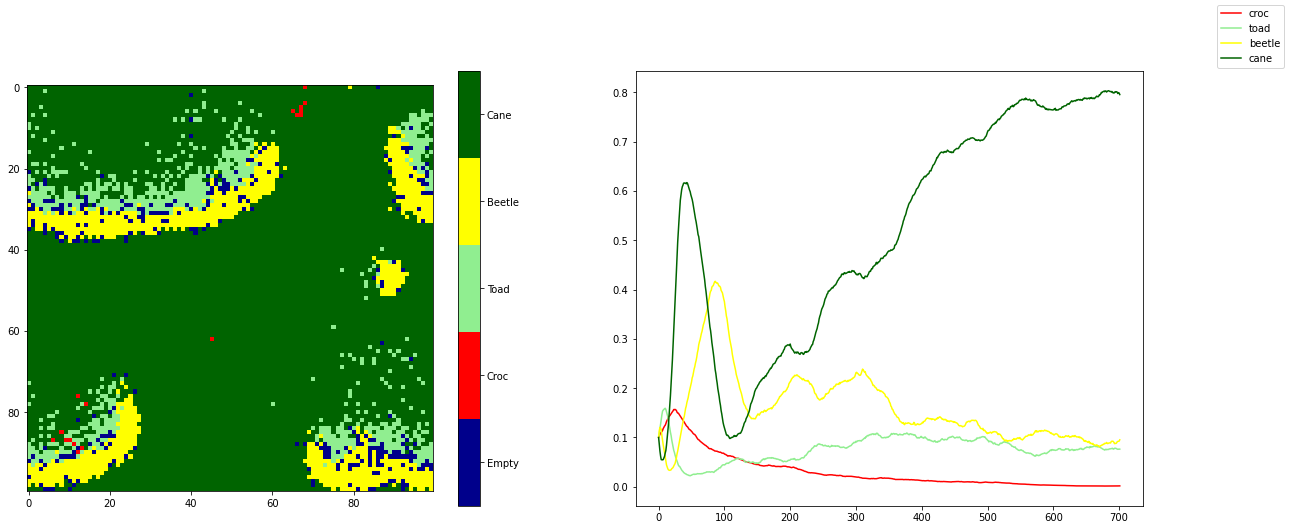

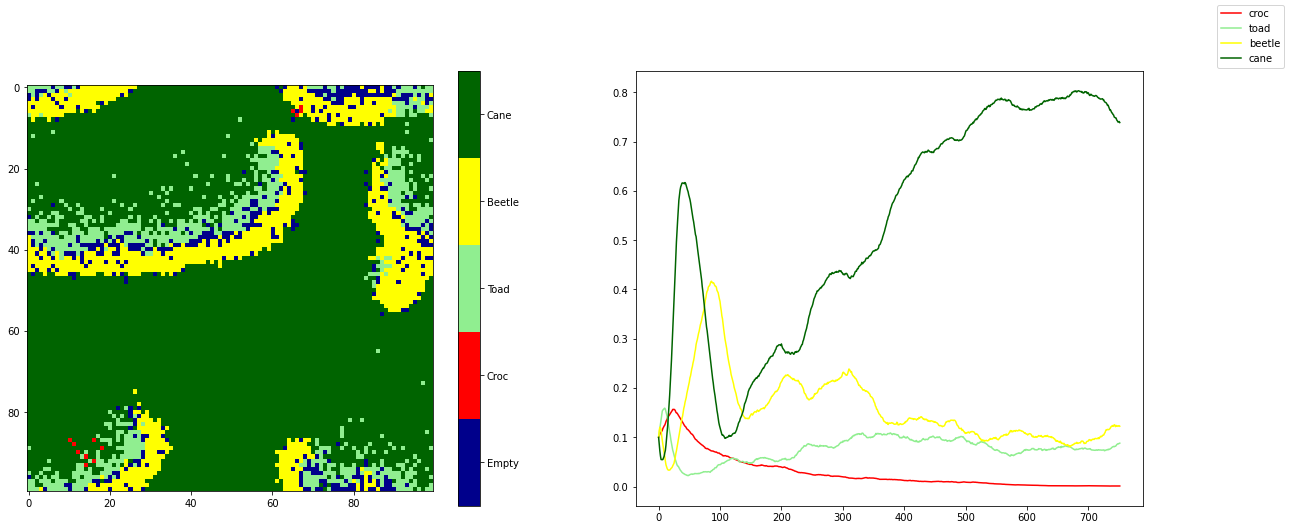

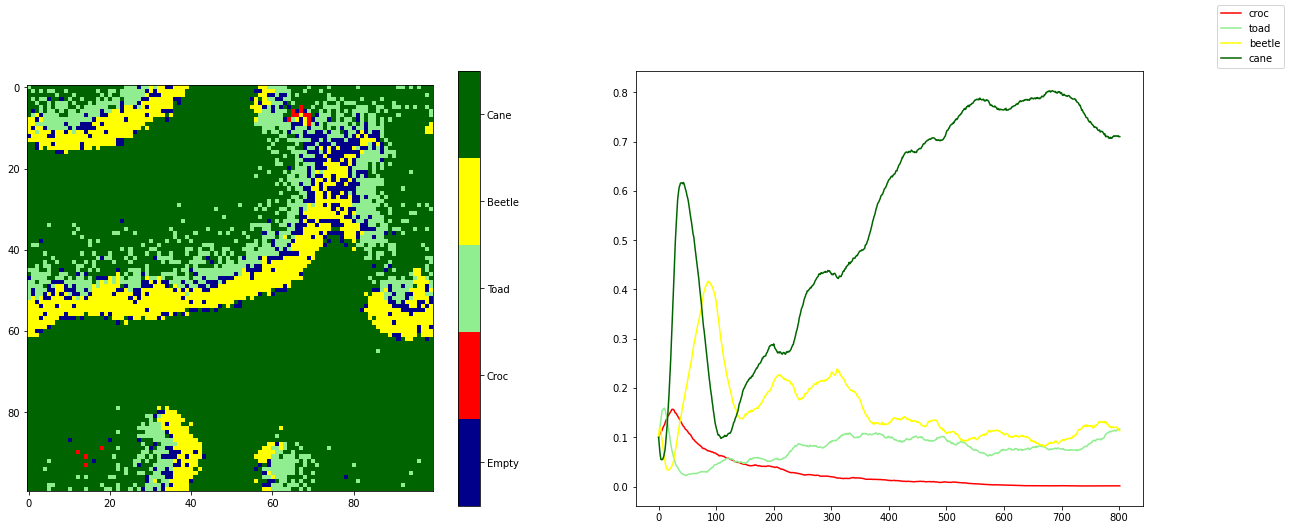

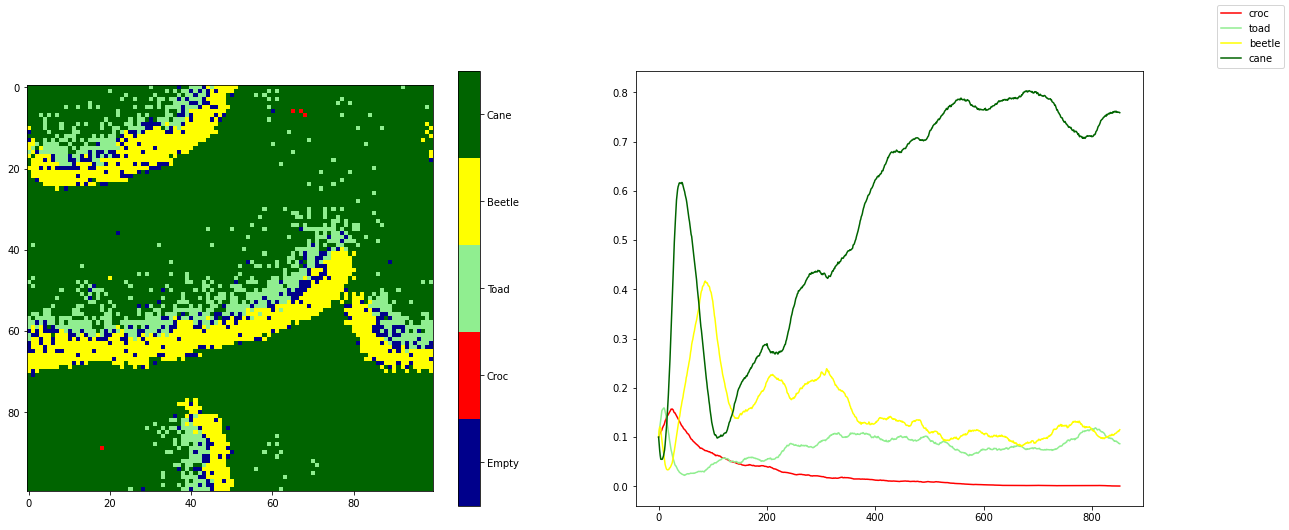

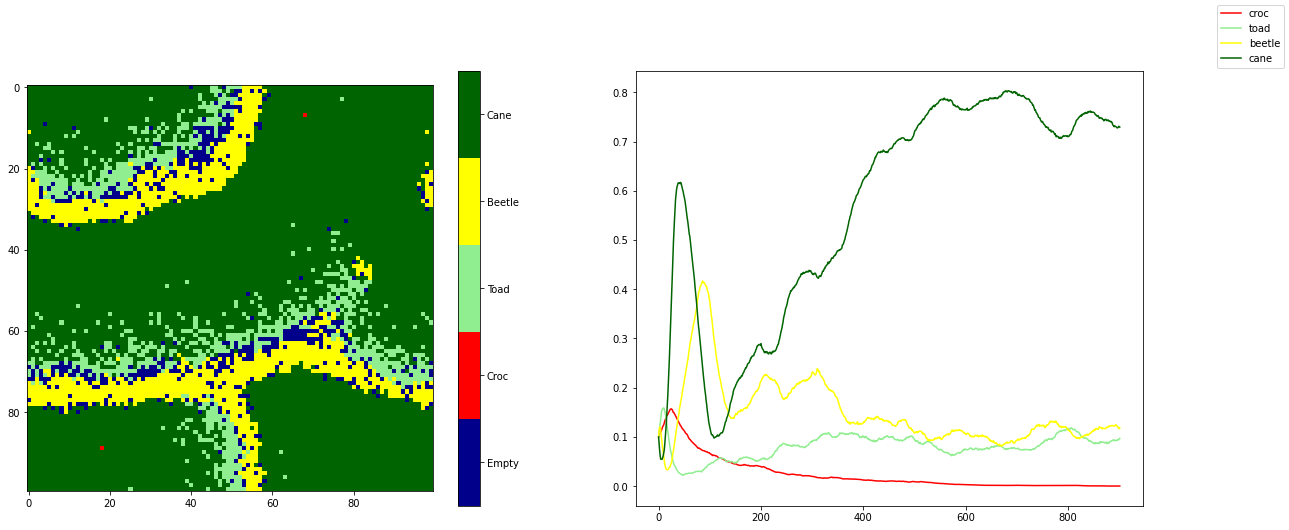

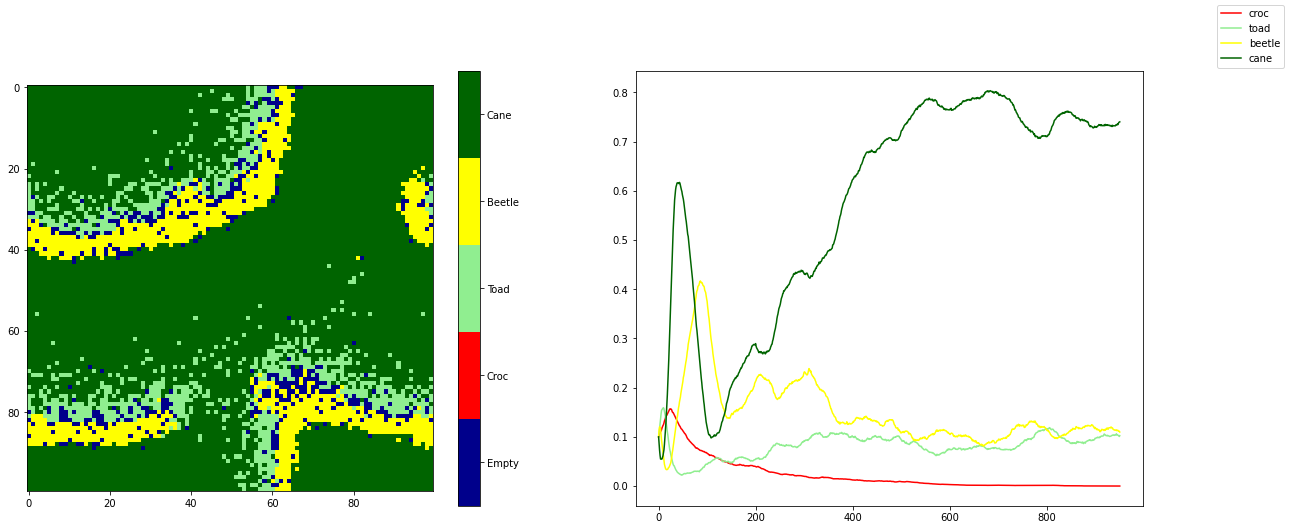

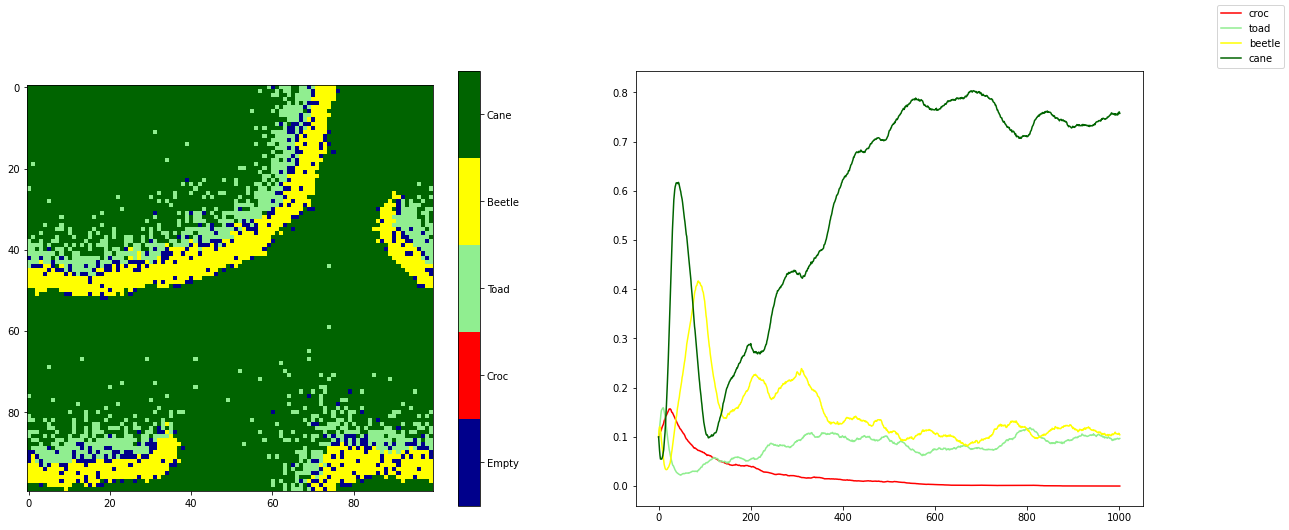

In [8]:
#This is where I experimented with the variables manually, making sure that they were also in line with what we might expect to see in reality
hunt_rep_rates = {'croc':1, 'toad':1, 'beetle':1, 'cane':0}
de_rates = {'croc':0.02, 'toad':0.05, 'beetle':0.05, 'cane':0}
hunt_rates = {'croc':0.05, 'toad':0.2, 'beetle':0.4, 'cane':0}
init_densities = {'croc':0.1, 'toad':0.1, 'beetle':0.1, 'cane':0.1}
rep_rates = {'croc':0, 'toad':0, 'beetle':0, 'cane':0.2}
random_ca = lotka_ca(gridsize = 100, hunt_birth_rate=hunt_rep_rates, death_rate=de_rates, success_rate=hunt_rates, densities=init_densities, reproduction_rate=rep_rates)

for i in range(1001):
  random_ca.update()
  if i%50 == 0:
    random_ca.observe()

In [9]:
final_densities_random = []

hunt_rep_rates = {'croc':1, 'toad':1, 'beetle':1, 'cane':0}
de_rates = {'croc':0.02, 'toad':0.05, 'beetle':0.05, 'cane':0}
hunt_rates = {'croc':0.05, 'toad':0.2, 'beetle':0.4, 'cane':0}
init_densities = {'croc':0.1, 'toad':0.1, 'beetle':0.1, 'cane':0.1}

for i in range(30):
  random_lotka = lotka_ca(hunt_birth_rate=hunt_rep_rates, death_rate=de_rates, success_rate=hunt_rates, densities=init_densities)
  for i in range(40):
    random_lotka.update()
  final_densities_random.append(random_lotka.densities_history)

In [10]:
def produce_finals(final_densities):
  croc_finals = []
  toad_finals = []
  beetle_finals = []
  cane_finals = []
  for i in final_densities:
    croc_finals.append(i['croc'])
    toad_finals.append(i['toad'])
    beetle_finals.append(i['beetle'])
    cane_finals.append(i['cane'])

  croc_finals = np.asarray(croc_finals)[:,-1]
  toad_finals = np.asarray(toad_finals)[:,-1]
  beetle_finals = np.asarray(beetle_finals)[:,-1]
  cane_finals = np.asarray(cane_finals)[:,-1]
  finals = [croc_finals, toad_finals, beetle_finals, cane_finals]
  return finals

In [11]:
def plot_col_hist_of_densities(finals, classes = True, grades = False):
 
  plt.figure(figsize=(10,8))
  for i, j in enumerate(finals):
      plt.scatter(sts.uniform.rvs(loc=i+1-0.2, scale=0.4, size=len(j)), 
                j, s=40, alpha=1)
      
  means = [np.mean(i) for i in finals]

  plt.plot(range(1, 5),
          means, 
          marker='_',linewidth=0,color="black",alpha=1,markersize=20)

  plt.xticks(range(1, 5), 
            ['Crocs', 'Toads', 'Beetles', 'Sugar Cane'])
  
  plt.grid(True, alpha=0.25, axis='y')
  
  plt.ylabel('Final Densities')
  plt.xlabel("Species")
  plt.show()

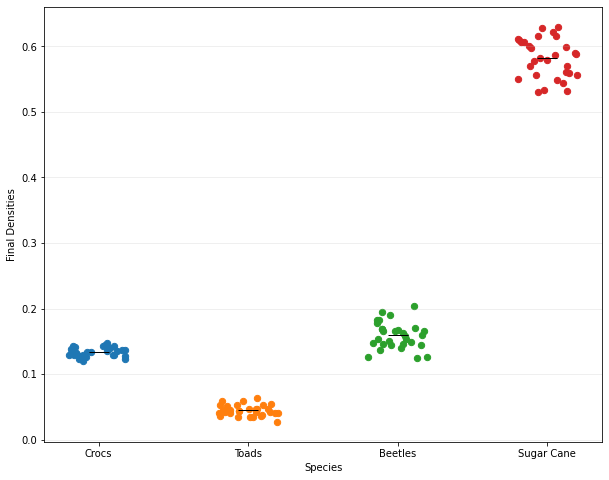

In [12]:
random_finals = produce_finals(final_densities_random)
plot_col_hist_of_densities(random_finals)

# Does the Lotka-Volterra Predicted k Replicate for the CA?

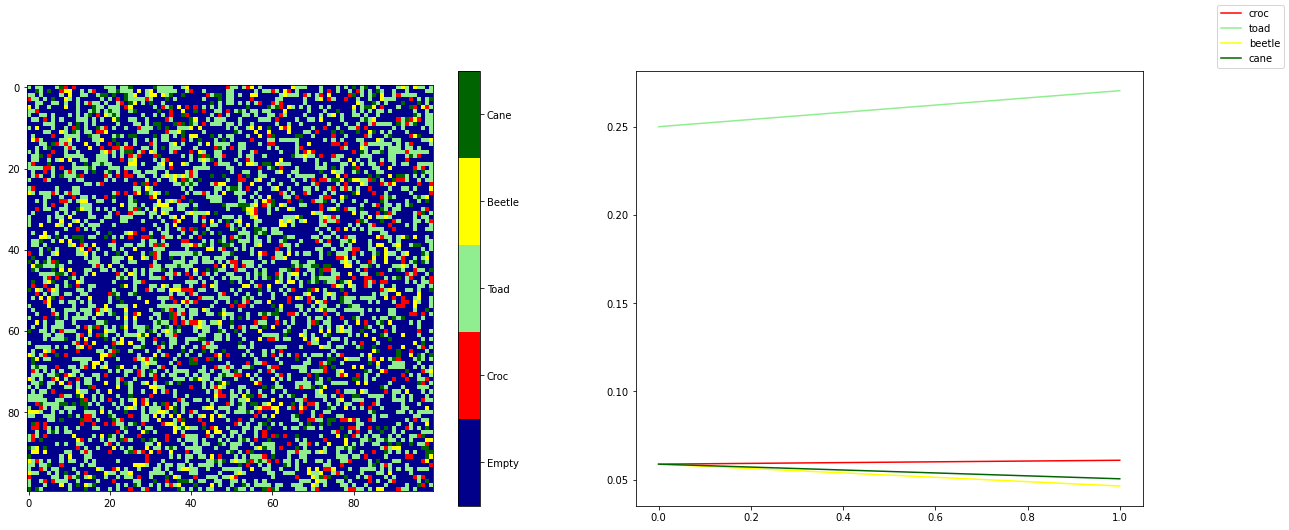

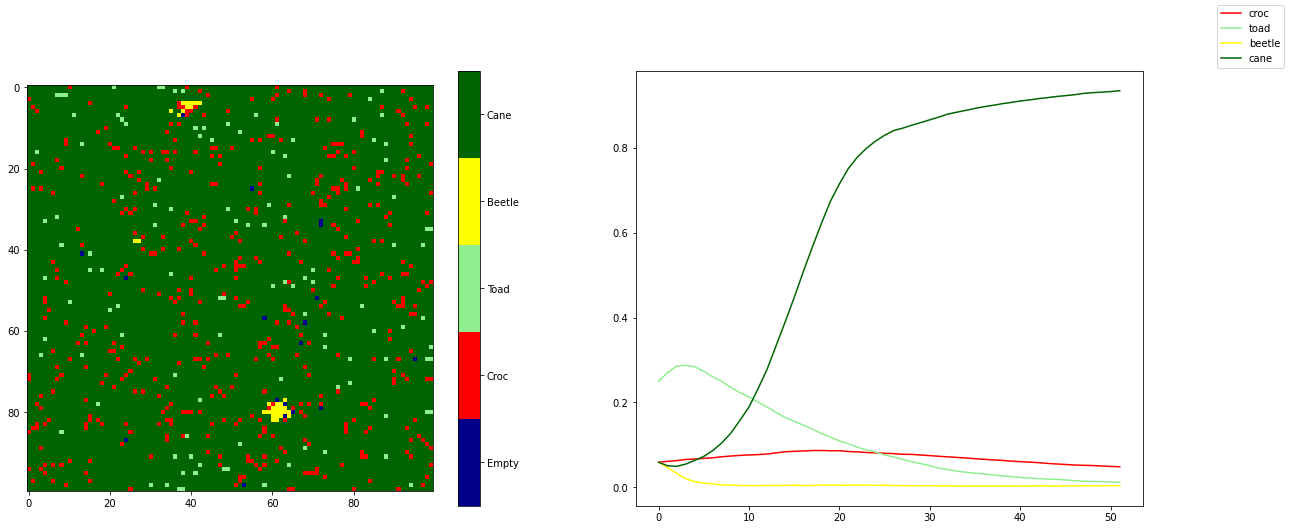

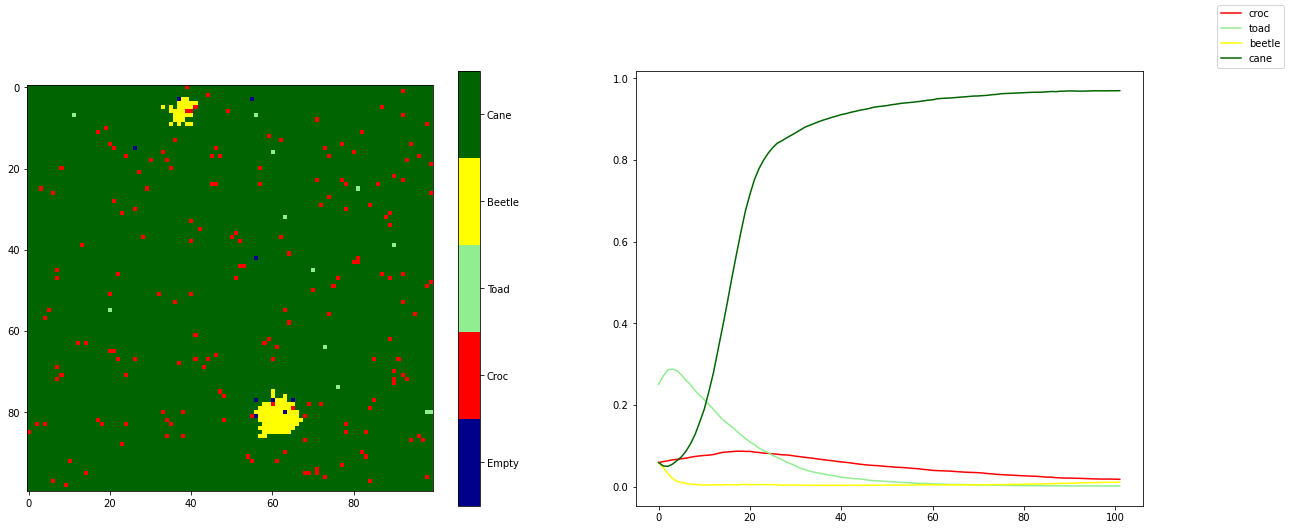

In [13]:
#This is where I experimented with the variables manually, making sure that they were also in line with what we might expect to see in reality
hunt_rep_rates = {'croc':1, 'toad':1, 'beetle':1, 'cane':0}
de_rates = {'croc':0.02, 'toad':0.05, 'beetle':0.05, 'cane':0}
hunt_rates = {'croc':0.05, 'toad':0.2, 'beetle':0.4, 'cane':0}

#Here I only change the initial densities below:
init_densities = {'croc':0.0588, 'toad':0.25, 'beetle':0.0588, 'cane':0.0588}
rep_rates = {'croc':0, 'toad':0, 'beetle':0, 'cane':0.2}
random_ca = lotka_ca(gridsize = 100, hunt_birth_rate=hunt_rep_rates, death_rate=de_rates, success_rate=hunt_rates, densities=init_densities, reproduction_rate=rep_rates)

for i in range(101):
  random_ca.update()
  if i%50 == 0:
    random_ca.observe()

# Pseudo Metropolis-Hastings MCMC Experiment

In [14]:
#This first function replaces the likelihood function of the metropolis hastings algorithm.
#It will output 
def species_lost_dist(rep_rates, de_rates, hunt_rates, init_densities):
  lotka_simul = lotka_ca(densities = init_densities, success_rate = hunt_rates, death_rate = de_rates, hunt_birth_rate=rep_rates)
  for i in range(20):
    lotka_simul.update()
  last_densities = []
  for i in init_densities.keys():
    last_densities.append(lotka_simul.densities_history[i][-1])
  num_species_lost = 0
  for i in ['croc', 'toad', 'beetle', 'cane']:
    if lotka_simul.densities_history[i][-1] < 0.01:
      num_species_lost += 1
  return np.mean(last_densities)/(num_species_lost+1)#Note that the output value is the average of the final densities for the populations of the 4 different species


hunt_rep_rates = {'croc':1, 'toad':1, 'beetle':1, 'cane':0}
de_rates = {'croc':0.02, 'toad':0.05, 'beetle':0.05, 'cane':0}
hunt_rates = {'croc':0.05, 'toad':0.2, 'beetle':0.4, 'cane':0}
init_densities = {'croc':0.1, 'toad':0.1, 'beetle':0.1, 'cane':0.1}
species_lost_dist(rep_rates, de_rates, hunt_rates, init_densities)

def mcmc_parameter_opt(current_likelihood, rep_rates, de_rates, hunt_rates, init_densities, n_trials = 100):
  rejections = 0
  mcmc_results = []
  n_trials = n_trials
  for j in range(n_trials):
    print(f'Trial Num {j}')
    #new_rep_rates = {} #I commented out the other parameters, as I will only optimize the initial densities, but i've experimented with optimizing for all of them (results weren't great)
    #new_de_rates = {}
    #new_hunt_rates = {}
    new_init_densities = {}
    for i in rep_rates.keys():
      #new_rep_rates[i] = rep_rates[i] + sts.norm.rvs(0, 0.05)
      #new_de_rates[i] = de_rates[i] + sts.norm.rvs(0, 0.05)  
      #new_hunt_rates[i] = hunt_rates[i] + sts.norm.rvs(0, 0.05)   
      new_init_densities[i] = init_densities[i] + sts.norm.rvs(0, 0.05)
      if new_init_densities[i] >= 0.2:
        new_init_densities[i] = np.random.uniform(low = 0, high = 0.2)
      if new_init_densities[i] < 0:
        new_init_densities[i] = np.random.uniform(low = 0, high = 0.2)

  
    new_likelihood = species_lost_dist(rep_rates, de_rates, hunt_rates, new_init_densities)
    r = new_likelihood/current_likelihood

    if np.random.uniform(0, 1) < r:
        #rep_rates = new_rep_rates
        #de_rates = new_de_rates
        #hunt_rates = new_hunt_rates
        init_densities = new_init_densities
    else:
      rejections += 1
    mcmc_results.append([rep_rates, de_rates, hunt_rates, init_densities])
  return mcmc_results
  
results = mcmc_parameter_opt(species_lost_dist(rep_rates, de_rates, hunt_rates, init_densities), rep_rates, de_rates, hunt_rates, init_densities)

Trial Num 0
Trial Num 1
Trial Num 2
Trial Num 3
Trial Num 4
Trial Num 5
Trial Num 6
Trial Num 7
Trial Num 8
Trial Num 9
Trial Num 10
Trial Num 11
Trial Num 12
Trial Num 13
Trial Num 14
Trial Num 15
Trial Num 16
Trial Num 17
Trial Num 18
Trial Num 19
Trial Num 20
Trial Num 21
Trial Num 22
Trial Num 23
Trial Num 24
Trial Num 25
Trial Num 26
Trial Num 27
Trial Num 28
Trial Num 29
Trial Num 30
Trial Num 31
Trial Num 32
Trial Num 33
Trial Num 34
Trial Num 35
Trial Num 36
Trial Num 37
Trial Num 38
Trial Num 39
Trial Num 40
Trial Num 41
Trial Num 42
Trial Num 43
Trial Num 44
Trial Num 45
Trial Num 46
Trial Num 47
Trial Num 48
Trial Num 49
Trial Num 50
Trial Num 51
Trial Num 52
Trial Num 53
Trial Num 54
Trial Num 55
Trial Num 56
Trial Num 57
Trial Num 58
Trial Num 59
Trial Num 60
Trial Num 61
Trial Num 62
Trial Num 63
Trial Num 64
Trial Num 65
Trial Num 66
Trial Num 67
Trial Num 68
Trial Num 69
Trial Num 70
Trial Num 71
Trial Num 72
Trial Num 73
Trial Num 74
Trial Num 75
Trial Num 76
Trial Num

In [15]:
rep_rates = [results[i][0] for i in range(100)]
de_rates = [results[i][1] for i in range(100)]
hunt_rates = [results[i][2] for i in range(100)]
init_densities = [results[i][3] for i in range(100)]

In [16]:
def get_mean_rate(rates):
  mean_rates = {'croc':0, 'toad':0, 'beetle':0, 'cane':0}

  for i in rates:
    mean_rates['croc'] += i['croc']
    mean_rates['toad'] += i['toad']
    mean_rates['beetle'] += i['beetle']
    mean_rates['cane'] += i['cane']

  for i in mean_rates.keys():
    mean_rates[i] = mean_rates[i]/len(rates)
  return mean_rates

mean_rep_rates = get_mean_rate(rep_rates)
mean_de_rates = get_mean_rate(de_rates)
mean_hunt_rates = get_mean_rate(hunt_rates)
mean_init_densities = get_mean_rate(init_densities)

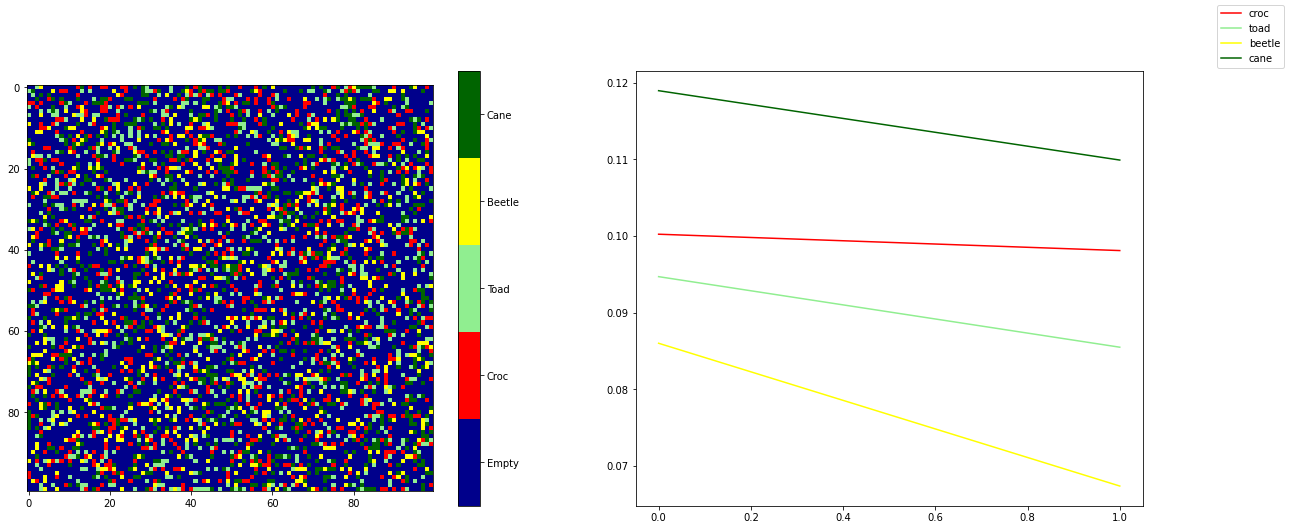

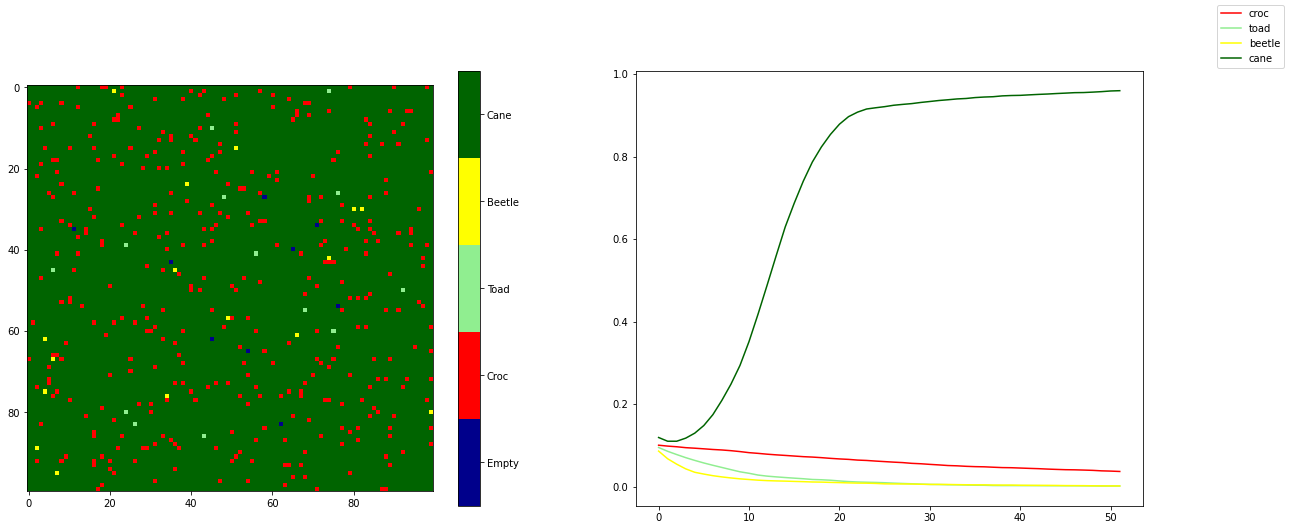

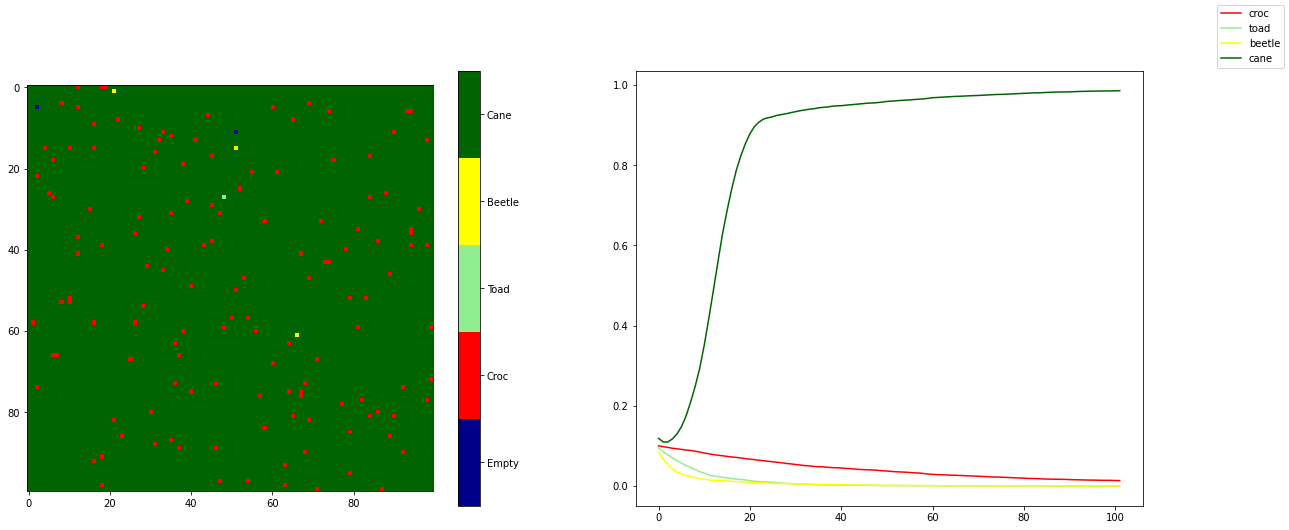

In [17]:
rep_rates = mean_rep_rates
de_rates = mean_de_rates
hunt_rates = mean_hunt_rates
init_densities = mean_init_densities
mcmc_ca = lotka_ca(gridsize = 100, hunt_birth_rate=rep_rates, death_rate=de_rates, success_rate=hunt_rates, densities=init_densities)

for i in range(101):
  mcmc_ca.update()
  if i%50 == 0:
    mcmc_ca.observe()

In [18]:
final_densities_mcmc = []
for i in range(50):
  mcmc_lotka = lotka_ca(hunt_birth_rate=mean_rep_rates, death_rate=mean_de_rates, success_rate=mean_hunt_rates, densities=mean_init_densities)
  for i in range(15):
    mcmc_lotka.update()
  final_densities_mcmc.append(mcmc_lotka.densities_history)

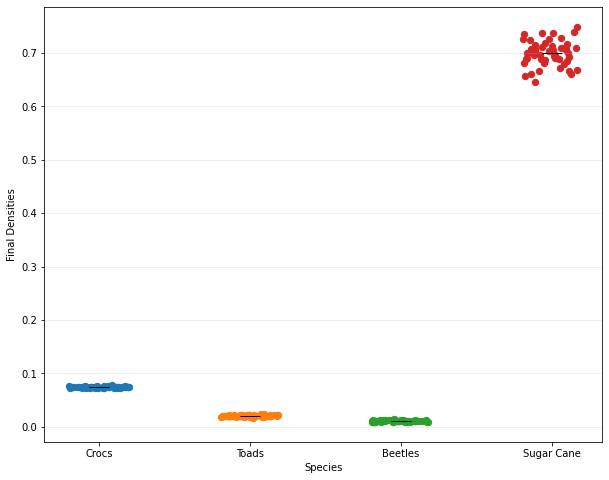

In [19]:
finals = produce_finals(final_densities_mcmc)
plot_col_hist_of_densities(finals)

# MFA Experiment

I did not include this experiment in my write-up because the caluculations for the mean-field analysis of this CA soon ran out of hand. With more time I might have been able to create an effective system of equations that would give us precise equilibrium predictions.



In [20]:
def d_toad(lotka_sim):
  sum1 = 0
  sum2 = 0
  for i in range(24):
    sum1 += sps.binom(24, i)*lotka_sim.densities['toad']*(1-lotka_sim.densities['beetle'])**24*lotka_sim.success_rate['toad']*lotka_sim.reproduction_rate['toad']*(1/24)
    sum2 += sps.binom(24, i)*lotka_sim.densities['toad']*(1-lotka_sim.densities['beetle'])**24*lotka_sim.success_rate['toad']*(1/24)
  sum3 = (1-lotka_sim.densities['beetle']**24)*(1-lotka_sim.success_rate['toad'])*(1-(1-lotka_sim.densities['beetle']-lotka_sim.densities['croc']-lotka_sim.densities['cane']-lotka_sim.densities['toad']))**24
  return sum1+sum2+sum3

# Bayesian Optimization


In [21]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11687 sha256=d58a1fe69b00c4a36a9b01136a30f4e51e05bd665af82ae6b2301d19ab5b90db
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [22]:
def lost_species(croc_hunt_rate, croc_rep_rate, croc_de_rate, croc_init_density, toad_hunt_rate, toad_rep_rate, toad_de_rate, toad_init_density, beetle_hunt_rate, beetle_rep_rate, beetle_de_rate, beetle_init_density, cane_hunt_rate, cane_rep_rate, cane_de_rate, cane_init_density):
  densities = {}
  densities['croc'] = croc_init_density
  densities['toad'] = toad_init_density
  densities['beetle'] = beetle_init_density
  densities['cane'] = cane_init_density

  hunt_birth_rate = {}
  hunt_birth_rate['croc'] = croc_de_rate
  hunt_birth_rate['toad'] = toad_de_rate
  hunt_birth_rate['beetle'] = beetle_de_rate
  hunt_birth_rate['cane'] = cane_de_rate

  success_rate = {}
  success_rate['croc'] = croc_hunt_rate
  success_rate['toad'] = toad_hunt_rate
  success_rate['beetle'] = beetle_hunt_rate
  success_rate['cane'] = cane_hunt_rate

  death_rate = {}
  death_rate['croc'] = croc_de_rate
  death_rate['toad'] = toad_de_rate
  death_rate['beetle'] = beetle_de_rate
  death_rate['cane'] = cane_de_rate




  lotka_simul = lotka_ca(densities = densities)#, success_rate = hunt_rates, death_rate = de_rates, hunt_birth_rate=rep_rates)
  for i in range(20):
    lotka_simul.update()
  last_densities = []
  for i in init_densities.keys():
    last_densities.append(lotka_simul.densities_history[i][-1])
  num_species_lost = 0
  for i in ['croc', 'toad', 'beetle', 'cane']:
    if lotka_simul.densities_history[i][-1] < 0.01:
      num_species_lost += 1
  return np.mean(last_densities)/(num_species_lost+1)


In [23]:
dict_params = {"croc_hunt_rate":(0.001, 0.9),
               "croc_rep_rate":(0.001, 0.9),
               "croc_de_rate":(0.001, 0.9),
               "croc_init_density":(0.001, 0.2),
               "toad_hunt_rate":(0.001, 0.9),
               "toad_rep_rate":(0.001, 0.9),
               "toad_de_rate":(0.001, 0.9),
               "toad_init_density":(0.001, 0.2),
               "beetle_hunt_rate":(0.001, 0.9),
               "beetle_rep_rate":(0.001, 0.9),
               "beetle_de_rate":(0.001, 0.9),
               "beetle_init_density":(0.001, 0.2),
               "cane_hunt_rate":(0.001, 0.9),
               "cane_rep_rate":(0.001, 0.9),
               "cane_de_rate":(0.001, 0.9),
               "cane_init_density":(0.001, 0.2)}

In [24]:
from bayes_opt import BayesianOptimization

Bayes_Opt = BayesianOptimization(lost_species, dict_params)
Bayes_Opt.maximize(init_points=10, n_iter=30, acq='ei', xi=0.0)

|   iter    |  target   | beetle... | beetle... | beetle... | beetle... | cane_d... | cane_h... | cane_i... | cane_r... | croc_d... | croc_h... | croc_i... | croc_r... | toad_d... | toad_h... | toad_i... | toad_r... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.1895   |  0.7067   |  0.2513   |  0.02992  |  0.02297  |  0.01404  |  0.657    |  0.07509  |  0.4132   |  0.8494   |  0.6906   |  0.1745   |  0.05696  |  0.731    |  0.5964   |  0.03784  |  0.1421   |
|  2        |  0.03568  |  0.3274   |  0.2077   |  0.1846   |  0.6604   |  0.1743   |  0.09369  |  0.02432  |  0.5774   |  0.428    |  0.08094  |  0.1445   |  0.4337   |  0.2971   |  0.5058   |  0.1417   |  0.6084   |
|  3        |  0.1091   |  0.8806   |  0.2367   |  0.172    |  0.6507   |  0.6397   |  0.5414   |  0.1336   |  0.5994   |  0.099

In [25]:
Bayes_Opt.max

{'params': {'beetle_de_rate': 0.7067489463585955,
  'beetle_hunt_rate': 0.25125682152147816,
  'beetle_init_density': 0.029916564241217903,
  'beetle_rep_rate': 0.022970831256535314,
  'cane_de_rate': 0.014035133266716023,
  'cane_hunt_rate': 0.6569679771572536,
  'cane_init_density': 0.07509118318107855,
  'cane_rep_rate': 0.4132253144308029,
  'croc_de_rate': 0.8494075375387038,
  'croc_hunt_rate': 0.6905562507946733,
  'croc_init_density': 0.17450649449246813,
  'croc_rep_rate': 0.056956689584216916,
  'toad_de_rate': 0.7310364793554928,
  'toad_hunt_rate': 0.5964213936977721,
  'toad_init_density': 0.037840314228968955,
  'toad_rep_rate': 0.14207166878712968},
 'target': 0.18955}

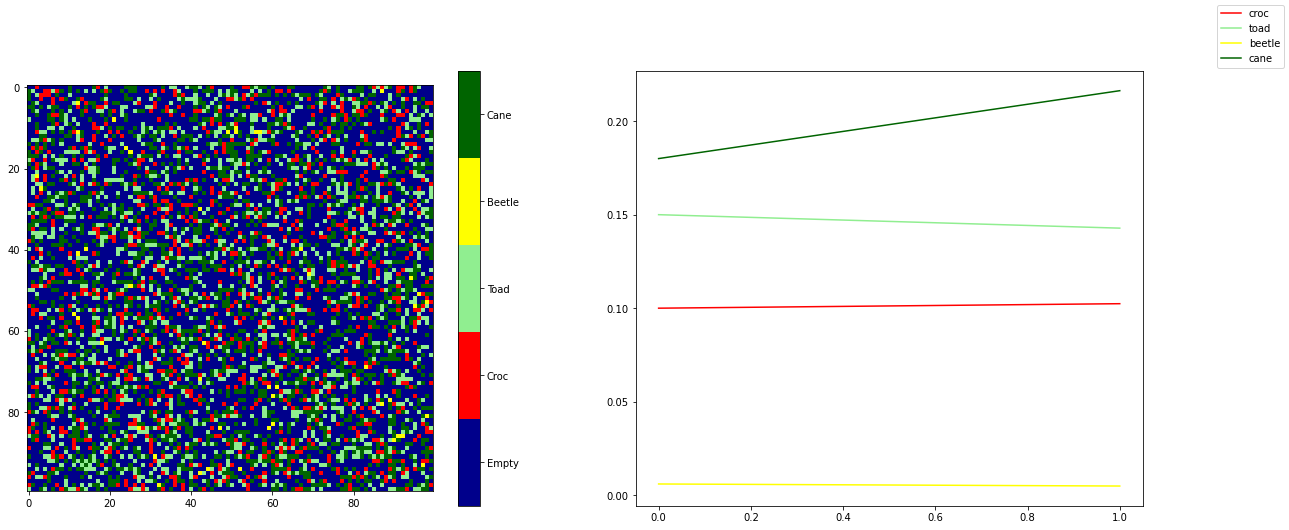

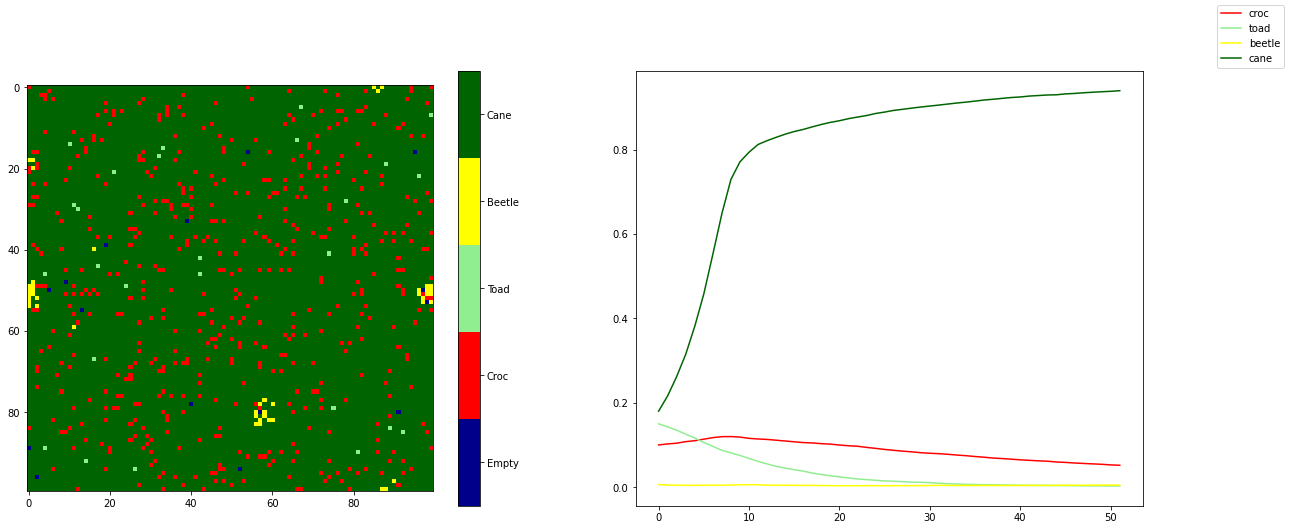

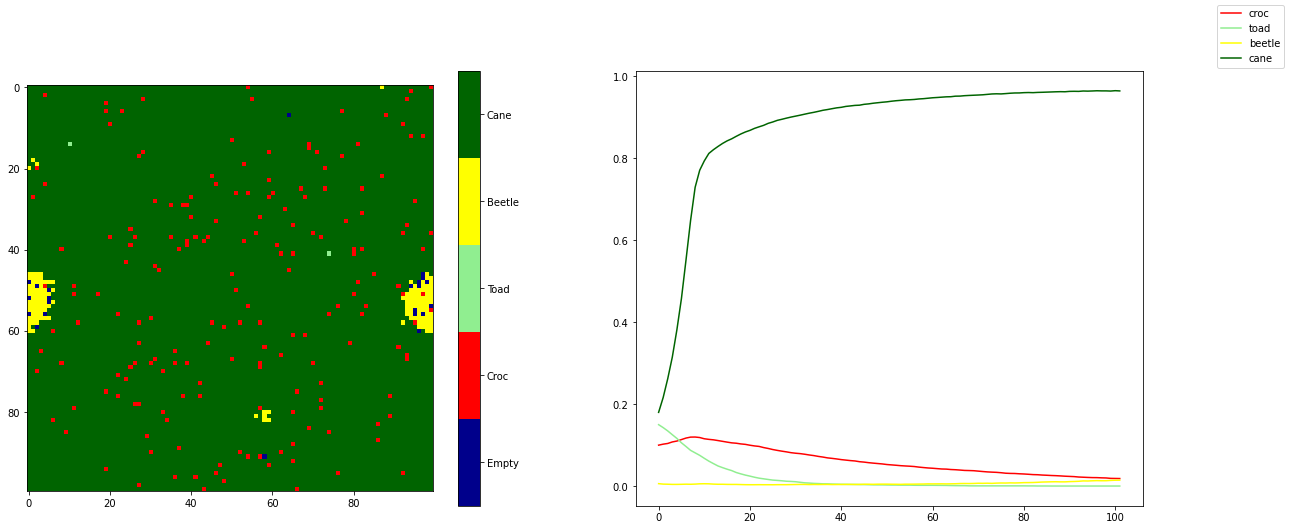

In [26]:
init_densities = {'croc':0.1, 'toad':0.15, 'beetle':0.006, 'cane':0.18}

bayesian_ca = lotka_ca(gridsize = 100, densities=init_densities)

for i in range(101):
  bayesian_ca.update()
  if i%50 == 0: #changing the modulo gives you more or less frames 
    bayesian_ca.observe()

In [27]:
#Takes around 6 minutes to run
init_densities = {'croc':0.1, 'toad':0.15, 'beetle':0.006, 'cane':0.18}
final_densities = []

for i in range(30):
  bayes_opt_lotka = lotka_ca(densities=init_densities)
  for i in range(40):
    bayes_opt_lotka.update()
  final_densities.append(bayes_opt_lotka.densities_history)


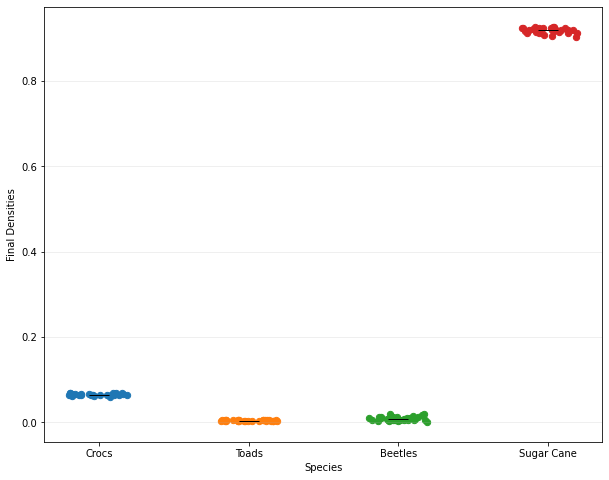

In [28]:
bayesian_finals = produce_finals(final_densities)
plot_col_hist_of_densities(bayesian_finals)

# Final Densities Comparisson

In [29]:
means_bayesian_finals = [np.mean(i) for i in bayesian_finals]
err_bayesian_finals = abs(means_bayesian_finals - np.array([np.quantile(i, 0.025) for i in bayesian_finals]))

means_random_finals = [np.mean(i) for i in random_finals]
err_means_random_finals = abs(means_random_finals - np.array([np.quantile(i, 0.025) for i in random_finals]))

means_finals = [np.mean(i) for i in finals]
err_finals = abs(means_finals - np.array([np.quantile(i, 0.025) for i in finals]))

## Comparing Metrics

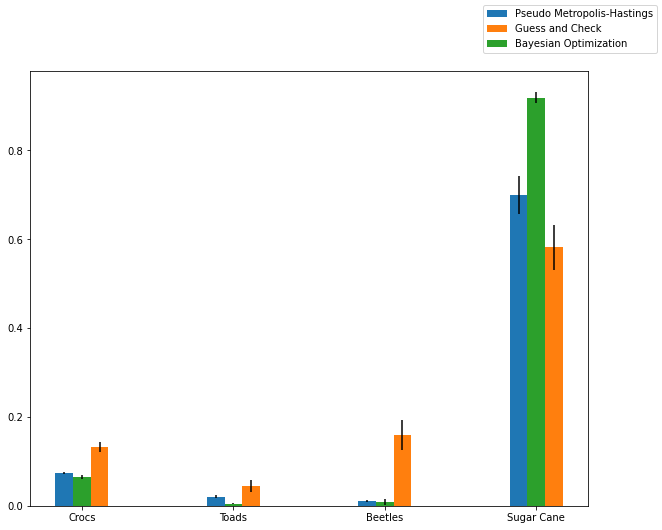

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))

ind = np.arange(4)
width = 0.35

rects1 = ax.bar(ind-width/3, means_finals, width/3, yerr = err_finals, label='Pseudo Metropolis-Hastings')
rects2 = ax.bar(ind+width/3, means_random_finals, width/3, yerr = err_means_random_finals, label='Guess and Check')
rects3 = ax.bar(ind, means_bayesian_finals, width/3, yerr = err_bayesian_finals, label='Bayesian Optimization')
ax.set_xticks(ind)
ax.set_xticklabels(('Crocs', 'Toads', 'Beetles', 'Sugar Cane'))
fig.legend()